<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal processing 

Today we're going to dive into signal processing techniques (*FFT, DCT, Wavelets transform, ...*) with a focus on data compression.<br>

Data compression is a fascinating problem, deeply rooted in *information theory*. <br>
The various data compression techniques developed are based on the idea that each signal can be viewed as the *linear combination* of some simpler signals. Underlying this idea is the assumption that each signal was generated by a combination of simple processes. <br>
Finding a solution to the data compression problem then can be decomposed in 2 sub-problems: 
- indentifying a set of base signals that can have generated the signal we're observing (different solutions to this problem lead to different techniques) ;
- finding the linear combination coefficients that can express this signal with respect to the selected base.

Today we're focusing on identifying signal bases that can lead to **sparse signal representations**. As you can imagine, a sparse representation makes it easier to compress the original signal. 



## Haar Wavelets 

The first signal processing technique we're going to look at is the Wavelets transofrm. In particular we'll use a discrete type of wavelet: the *Haar Wavelet*. 

![Haar](http://fourier.eng.hmc.edu/e161/lectures/figures/Haar_8.gif)

The Haar Wavelets are a parametric signal basis, uniquely identified by a dimension parameter. You have to think of this dimension parameter as the discretization level of your signal basis. Using a basis of dimension 4 means that you'll span the input signal with 4 different waves, one of which is always just a constant.All the other basis vectors are obtained by scaling by power of two and translating the mother wavelet (top row, second figure).

In [0]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [0]:
def haarMatrix(n):
  """The algorithm to compute recursively the haar matrix can be 
  found here : https://iopscience.iop.org/article/10.1088/0305-4470/36/24/316/pdf,
  equations 9 and 10"""
  # Allow only size n of power 2
  n = 2**np.ceil(np.log2(n))

  if n > 2: h = haarMatrix(n / 2)
  else: return np.array([[1, 1], [1, -1]])

  # calculate upper haar part
  h_n = np.kron(h, [1, 1])
  
  # calculate lower haar part 
  h_i = np.sqrt(n/2)*np.kron(np.eye(len(h)), [1, -1])

  # combine parts
  h = np.vstack((h_n, h_i))
  return h

In [13]:
haarMatrix(4)

array([[ 1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        , -1.        , -1.        ],
       [ 1.41421356, -1.41421356,  0.        , -0.        ],
       [ 0.        , -0.        ,  1.41421356, -1.41421356]])

Let's look at an Haar basis for a dimension of 16.

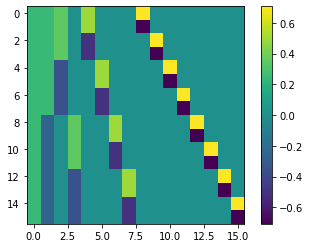

In [15]:
K = 16 
U = np.transpose(haarMatrix(K)/np.sqrt(K)) #the denominator scales the matrix to obtain an orthonormal basis 
plt.imshow(U, interpolation='nearest')
plt.colorbar()
plt.show()

You should look at the above plot column by column: each column represents a different wavelet.<br>
Let's try to look at them in a more wavy form. 

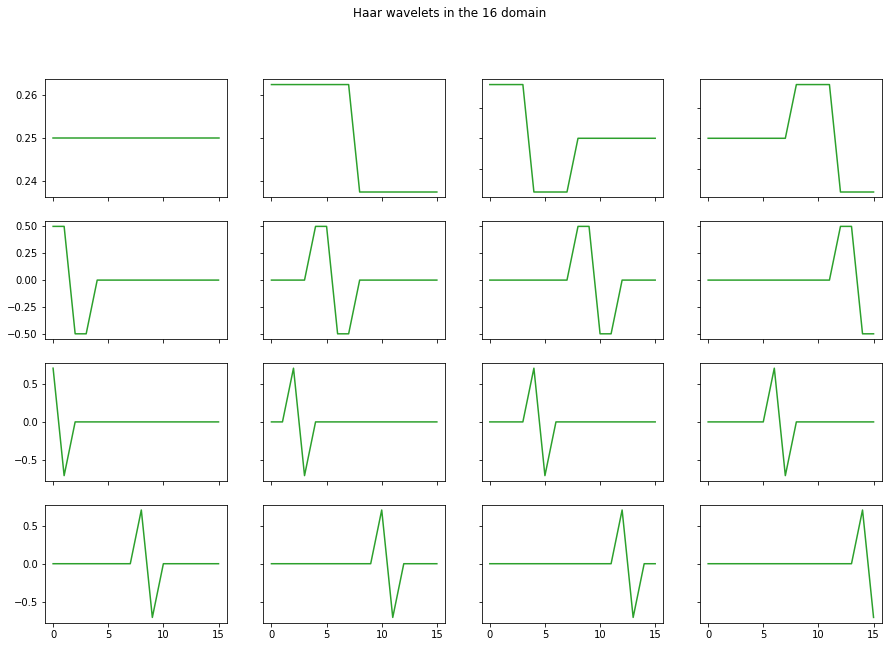

In [32]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))
fig.suptitle('Haar wavelets in the 16 domain')
for i in range(4):
  for j in range(4):
    axs[i,j].plot(U[:,i*4+j], 'tab:green')

for ax in fig.get_axes():
    ax.label_outer()

Before applying the transformation let's double check that our signal basis is effectively orthonormal. <br>
Checking orthornormality is simple: the product $U^TU$ should give us the identity $I_{16}$.

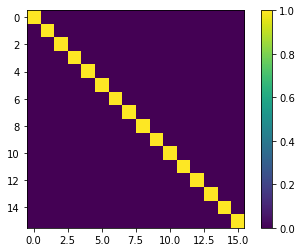

In [31]:
plt.imshow(np.dot(np.transpose(U),U), interpolation='nearest')
plt.colorbar()
plt.show()

### Applying the wavelet transform 

Now we'll hand-craft a signal to stury the effects of an Haar transform. Actually, we're going to build two different signals: a periodic one and a single-spike one, both corrupted by some Gaussian noise; and finally we're going to compare the results of the Haar transform in these two cases.

In [0]:
# we build a signal with length 128 
x = np.arange(0.1, 12.81, 0.1) 
h = np.zeros(128)
h[40:60] = 1
periodic = np.sin(x*3)*3
periodic = periodic+x
singlespike = np.sin(x)*h
singlespike2 
aperiodic = singlespike *10 

Text(0.5, 1.0, 'Aperiodic')

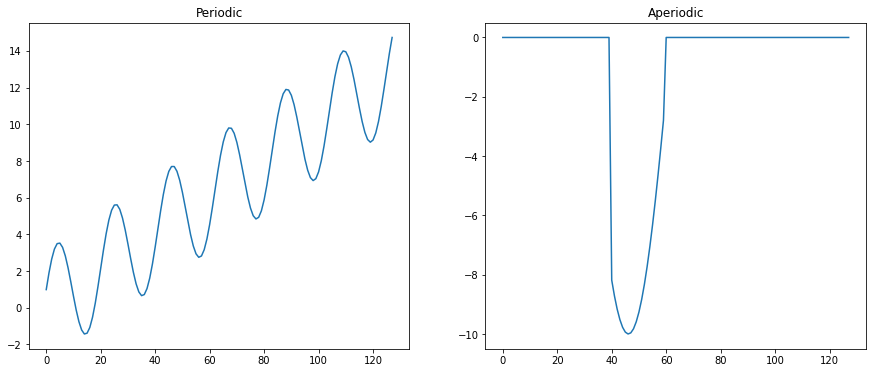

In [183]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(periodic)
ax1.set_title('Periodic')
ax2.plot(aperiodic)
ax2.set_title('Aperiodic')

We still need to add some noise. To have comparable results we'll add the same level of noise to both signals.

In [0]:
noise = np.random.normal(0,2,128)
signal1 = periodic + noise
signal2 = aperiodic + noise

Text(0.5, 1.0, 'Second signal')

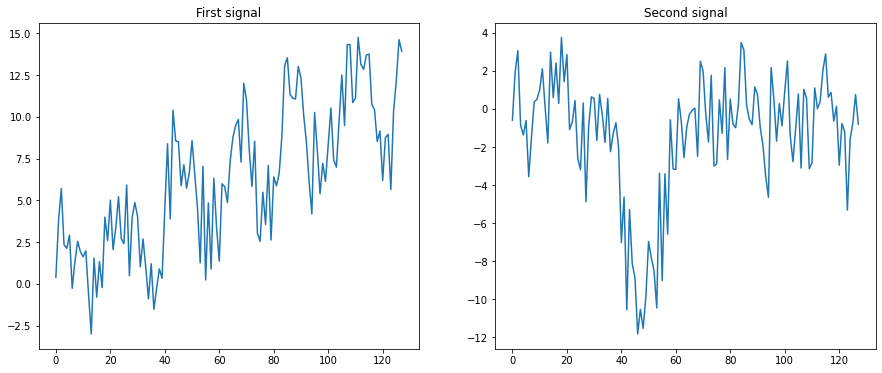

In [185]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(signal1)
ax1.set_title('First signal')
ax2.plot(signal2)
ax2.set_title('Second signal')

Now finally we can transform our inputs with our Haar wavelets.

In [0]:
U = np.transpose(haarMatrix(128)/np.sqrt(128))
spectrum1 = np.dot(np.transpose(U), signal1)
spectrum2 = np.dot(np.transpose(U), signal2)

Text(0.5, 1.0, 'Second spectrum')

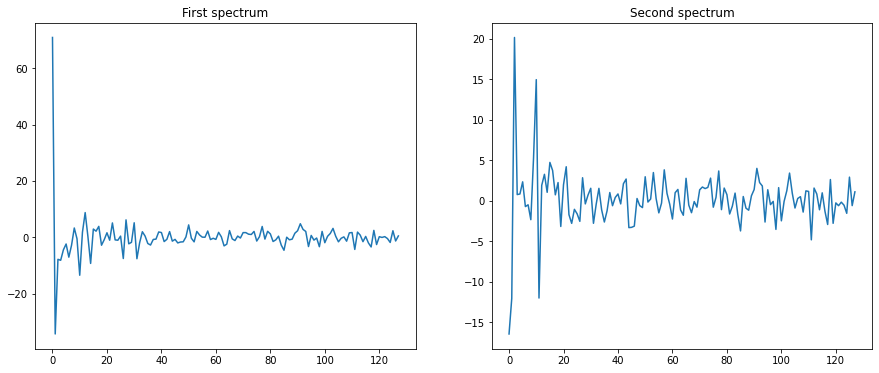

In [187]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(spectrum1)
ax1.set_title('First spectrum')
ax2.plot(spectrum2)
ax2.set_title('Second spectrum')

There seem to be two interesting spikes in the spectrum of the second signal, corresponding to two different base wavelets. 

### De-noising 

Now we'll try to denoise the signal by removing from the spectrum the low coefficients and re-transforming this filtered spectrum into the time domain. Easier done than said: since our transformation matrix is orthonormal we can easily obtain its inverse by the transpose operator. 

In [191]:
len(spectrum1 > 1)

128